# Regression Model Comparison Using Student VLE Model Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn import preprocessing
%matplotlib inline

## Aggregating and Prepocessing Data for Analysis

In [2]:
studentInfo = pd.read_csv('../__DATA__/VLEData/studentInfo.csv')
courses = pd.read_csv('../__DATA__/VLEData/courses.csv')
assessments = pd.read_csv('../__DATA__/VLEData/assessments.csv')
studentAssess = pd.read_csv('../__DATA__/VLEData/studentAssessment.csv')
studentReg = pd.read_csv('../__DATA__/VLEData/studentRegistration.csv')
studentVle = pd.read_csv('../__DATA__/VLEData/studentVle.csv')

In [3]:
###Compiling all CompVLE code into one cell.

#Combining Student Test performance with test information
AssessCompo = pd.merge(studentAssess, assessments, how="left", on=['id_assessment'])

#Converting scores to be weight adjusted to reflect the points contributed to overall class score
AssessCompo['wtadj_score'] = AssessCompo['score'] * AssessCompo['weight']/100

#Aggregating assessment scores for each individual in each class
AssessCompo1 = AssessCompo.groupby(['id_student','code_module','code_presentation']).sum()[['weight','wtadj_score']].reset_index()

#Dropping multiple test versions from the assessments dataframe so they don't aggregate into a 
#total score weight that deflates the students score (some classses had multiple test versions for one test) 
assessment2 = assessments.drop([62,72]).groupby(['code_module','code_presentation']).sum()['weight'].reset_index().rename(columns={'weight':'tot_weight'})

#Creating feature 'final_score' which is the percentage of all possible points in the course the students achieved
AssessCompo2 = pd.merge(AssessCompo1, assessment2, how='left', on=['code_module','code_presentation'])
AssessCompo2['final_score'] = round(100*AssessCompo2['wtadj_score']/AssessCompo2['tot_weight'], 2)

#Merging student assessment data with student demographic data
StudentComp = pd.merge(studentInfo, AssessCompo2, how='left', on=['code_module','code_presentation','id_student'])

#Aggregating clicks by individuals students in each class, and merging this aggregation with the rest of the info
clicks = studentVle.groupby(['code_module','code_presentation','id_student']).sum()['sum_click'].reset_index()
StudentComp1 = pd.merge(StudentComp, clicks, how='left', on=['code_module','code_presentation','id_student'])

#Merging student registration information with the master dataframe
VleFinalDF = pd.merge(StudentComp1, studentReg, how='left', on=['id_student','code_module','code_presentation'])

#Use the below code to see all of the colums included in the 
#cols = list(VleFinalDF.columns.values)

#Reording the columns in the final dataframe
cols = ['code_module',
 'code_presentation',
 'id_student',
 'gender',
 'region',
 'highest_education',
 'imd_band',
 'age_band',
 'num_of_prev_attempts',
 'studied_credits',
 'disability',
 'date_registration',
 'date_unregistration',
 'sum_click',
 'final_score',
 'final_result']

#This is the final data frame with raw information.
CompVle = VleFinalDF[cols]
display(CompVle.head())
print(CompVle.shape)

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,date_registration,date_unregistration,sum_click,final_score,final_result
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,-159.0,NaN,934.0,41.20,Pass
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,-53.0,NaN,1435.0,32.70,Pass
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,-92.0,12.0,281.0,NaN,Withdrawn
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,-52.0,NaN,2158.0,38.15,Pass
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,-176.0,NaN,1034.0,27.50,Pass


(32593, 16)


In [35]:
### Aggregated Code for Preprocessing

CompVlePP = pd.get_dummies(CompVle['code_module'])
CompVlePP = pd.concat([CompVlePP, pd.get_dummies(CompVle['code_presentation'])], axis = 1)
#CompVlePP = pd.concat([CompVlePP, pd.get_dummies(features['mod_presentation'])], axis = 1)
CompVlePP = pd.concat([CompVlePP, pd.get_dummies(CompVle['region'])], axis = 1)
CompVlePP = pd.concat([CompVlePP, pd.get_dummies(CompVle['gender'])], axis = 1)
CompVlePP = pd.concat([CompVlePP, pd.get_dummies(CompVle['highest_education'])], axis = 1)
#CompVlePP = pd.concat([CompVlePP, CompVle['sum_click']], axis = 1)

##Create a dataframe 'features' containing another preprocessing step for other features
features = pd.DataFrame(np.log(CompVle['sum_click'].fillna(0) + 1))
features = features.rename(columns={'sum_click':'log_sum_click'})
features['imd_band'] = CompVle['imd_band']
features['imd_band'] = features['imd_band'].replace({ '90-100%': 95 , '20-30%': 25 , '30-40%': 35 , '50-60%': 55 , '80-90%': 85, '70-80%': 75,
       '60-70%': 65, '40-50%' : 45 , '10-20' : 15, '0-10%': 5})
features['age_band'] = CompVle['age_band']
features['age_band'] = features['age_band'].replace({'55<=': 2 , '35-55' : 1 , '0-35' : 0})

##Preprocessing and Scaling log sum click
#float_array = features['log_sum_click'].values.astype(float).reshape(-1, 1)
#min_max_scaler = preprocessing.MinMaxScaler()
#scaled_array = min_max_scaler.fit_transform(float_array)
#CompVlePP['clicks_scaled'] = pd.DataFrame(scaled_array)

##Preprocessing Clicks to be powertransformed
clicks = (CompVle['sum_click'].fillna(0)).values.reshape(-1,1)
click_trans = preprocessing.power_transform(clicks, method = 'yeo-johnson')
clicktdf = pd.DataFrame(click_trans)
CompVlePP['clicks_trans'] = clicktdf

##Preprocessing and Scaling log imd_band
float_array = features['imd_band'].values.astype(float).reshape(-1, 1)
min_max_scaler = preprocessing.MinMaxScaler()
scaled_array = min_max_scaler.fit_transform(float_array)
CompVlePP['imd_band'] = pd.DataFrame(scaled_array)

CompVlePP['age_band'] = features['age_band']

##Binarizing the number of attempts for the course
X = CompVle['num_of_prev_attempts'].values.reshape(-1,1)
Binarize = preprocessing.Binarizer(0)
binary_array = Binarize.fit_transform(X)
CompVlePP['reattempted'] = pd.DataFrame(binary_array)

##Rescaling the studied_credits column
float_array = CompVle['studied_credits'].values.astype(float).reshape(-1, 1)
min_max_scaler = preprocessing.MinMaxScaler()
scaled_array = min_max_scaler.fit_transform(float_array)
CompVlePP['studied_credits'] = pd.DataFrame(scaled_array)

##Binarizing Disability
binary_disability = CompVle['disability'].replace({'Y':1,'N':0})
CompVlePP['disability'] = pd.DataFrame(binary_disability)

##Adding the Final Score Outcome Variable to the dataframe
CompVlePP = pd.concat([CompVlePP, CompVle['final_score']], axis = 1)

##Filling in missing values
CompVlePP['final_score'] = CompVlePP['final_score'].fillna(0)
CompVlePP['imd_band'] = CompVlePP['imd_band'].fillna(CompVlePP['imd_band'].mean())
CompVlePP['clicks_trans'] = CompVlePP['clicks_trans'].fillna(CompVlePP['clicks_trans'].min())
#CompVlePP['sum_click'] = CompVlePP['sum_click'].fillna(0)

##Adding and Binarizing Final Result feature (Pass/No Pass)
CompVlePP['final_result'] = CompVle['final_result']
CompVlePP.loc[CompVlePP['final_result'] == 'Pass', 'final_result'] = 1
CompVlePP.loc[CompVlePP['final_result'] == 'Distinction', 'final_result'] = 1
CompVlePP.loc[CompVlePP['final_result'] == 'Withdrawn', 'final_result'] = 0
CompVlePP.loc[CompVlePP['final_result'] == 'Fail', 'final_result'] = 0

display(CompVlePP.head())
CompVlePP.columns

,AAA,BBB,CCC,DDD,EEE,FFF,GGG,2013B,2013J,2014B,...,No Formal quals,Post Graduate Qualification,clicks_trans,imd_band,age_band,reattempted,studied_credits,disability,final_score,final_result
0,1,0,0,0,0,0,0,0,1,0,...,0,0,0.338121,1.000000,2,0,0.336,0,41.20,1
1,1,0,0,0,0,0,0,0,1,0,...,0,0,0.624849,0.222222,1,0,0.048,0,32.70,1
2,1,0,0,0,0,0,0,0,1,0,...,0,0,-0.323779,0.333333,1,0,0.048,1,0.00,0
3,1,0,0,0,0,0,0,0,1,0,...,0,0,0.925874,0.555556,1,0,0.048,0,38.15,1
4,1,0,0,0,0,0,0,0,1,0,...,0,0,0.403401,0.555556,0,0,0.048,0,27.50,1


Index(['AAA', 'BBB', 'CCC', 'DDD', 'EEE', 'FFF', 'GGG', '2013B', '2013J',
       '2014B', '2014J', 'East Anglian Region', 'East Midlands Region',
       'Ireland', 'London Region', 'North Region', 'North Western Region',
       'Scotland', 'South East Region', 'South Region', 'South West Region',
       'Wales', 'West Midlands Region', 'Yorkshire Region', 'F', 'M',
       'A Level or Equivalent', 'HE Qualification', 'Lower Than A Level',
       'No Formal quals', 'Post Graduate Qualification', 'clicks_trans',
       'imd_band', 'age_band', 'reattempted', 'studied_credits', 'disability',
       'final_score', 'final_result'],
      dtype='object')

## Regression Model Comparison

In [39]:
from sklearn.model_selection import cross_val_score
from sklearn import neighbors
from sklearn import linear_model
import statsmodels.formula.api as smf


Coefficients: 
 [[15.82584417]]

Intercept: 
 [24.24728469]

R-squared:
0.41240112176993204

Accuracies of various holdout groups in the data
[ 0.52065804  0.40530807  0.20059541  0.39701633 -0.38142559]


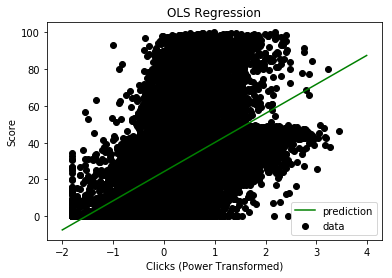

In [56]:
###OLS Regression
regr = linear_model.LinearRegression()
Y = CompVlePP['final_score'].values.reshape(-1,1)
X = CompVlePP['clicks_trans'].values.reshape(-1,1)
regr.fit(X,Y)

print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))
CVarray = cross_val_score(regr, X, Y, cv=5)
print('\nAccuracies of various holdout groups in the data')
print(CVarray)

# Set up our prediction line.
T = np.arange(-2, 4, .01)[:, np.newaxis]
# Trailing underscores are a common convention for a prediction.
Y_ = regr.predict(T)

plt.scatter(X, Y, c='k', label='data')
plt.plot(T, Y_, c='g', label='prediction')
plt.legend()
plt.ylabel('Score')
plt.xlabel('Clicks (Power Transformed)')
plt.title('OLS Regression')
plt.show()

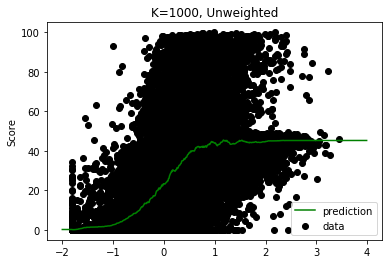

Unweighted Accuracy: 0.31 (+/- 1.86)


In [54]:
###KNN Regression
knn = neighbors.KNeighborsRegressor(n_neighbors=1000)
Y = CompVlePP['final_score'].values.reshape(-1,1)
X = CompVlePP['clicks_trans'].values.reshape(-1,1)
knn.fit(X,Y)

# Set up our prediction line.
T = np.arange(-2, 4, .01)[:, np.newaxis]

# Trailing underscores are a common convention for a prediction.
Y_ = knn.predict(T)

plt.scatter(X, Y, c='k', label='data')
plt.plot(T, Y_, c='g', label='prediction')
plt.legend()
plt.ylabel('Score')
plt.xlabel('Clicks (Power Transformed)')
plt.title('K=1000, Unweighted')
plt.show()

score = cross_val_score(knn, X, Y, cv=50)
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

Neither of the models demonstrate stable models based on the cross validation score check. But I would use the OLS regression model over the KNN model because the KNN model overfits to the cluster of data points at center right of the data, thus not capturing the variability of data higer above that cluster.